#ACx

In [ ]:
# box plots
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

width = pd.read_csv('/content/acx_wt_w_ko_noise_width_error_model.csv')


<ipython-input-27-e82faa01f32d>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle.loc[middle['Genotype'] == 'WT', 'Source'] = 'WT'
<ipython-input-27-e82faa01f32d>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_ko['Source'] = label
<ipython-input-27-e82faa01f32d>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

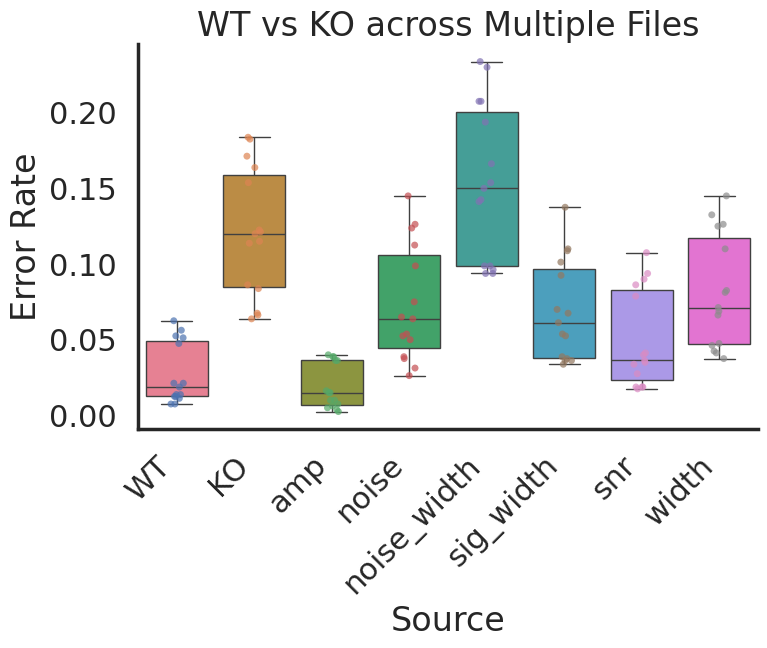

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re

# List of CSV files
csv_files = sorted(glob.glob("*.csv"))  # Adjust the pattern if needed

# Function to label octaves
def label_octaves(octave):
    if octave <= 0.3:
        return 'Low'
    elif 0.4 <= octave <= 0.7:
        return 'Middle'
    elif octave >= 0.8:
        return 'High'

all_data = []

for i, file in enumerate(csv_files):
    df = pd.read_csv(file)

    # Reshape the data to long format
    data_long = pd.melt(df, id_vars=['Octave Distance from CF'],
                        value_vars=['WT Repeat 1 Error Rate', 'KO Repeat 1 Error Rate',
                                    'WT Repeat 2 Error Rate', 'KO Repeat 2 Error Rate',
                                    'WT Repeat 3 Error Rate', 'KO Repeat 3 Error Rate',
                                    'WT Repeat 4 Error Rate', 'KO Repeat 4 Error Rate',
                                    'WT Repeat 5 Error Rate', 'KO Repeat 5 Error Rate'],
                        var_name='Genotype_Repeat', value_name='Error')

    # Extract genotype labels
    data_long['Genotype'] = data_long['Genotype_Repeat'].apply(lambda x: 'WT' if 'WT' in x else 'KO')
    data_long['Octaves'] = data_long['Octave Distance from CF']
    data_long['Octave_Label'] = data_long['Octaves'].apply(label_octaves)

    # Extract the middle range
    middle = data_long[data_long['Octave_Label'] == 'Middle']

    # Extract file label between 'ko_' and '_error'
    match = re.search(r'ko_(.*?)_error', file)
    label = match.group(1) if match else file

    # Keep WT + KO for first file, only KO for others
    if i == 0:
        middle.loc[middle['Genotype'] == 'WT', 'Source'] = 'WT'
        middle.loc[middle['Genotype'] == 'KO', 'Source'] = 'KO'
        all_data.append(middle)
    else:
        middle_ko = middle[middle['Genotype'] == 'KO']
        middle_ko['Source'] = label
        all_data.append(middle_ko)

# Combine all data into a single dataframe
final_data = pd.concat(all_data, ignore_index=True)

# Plot
sns.set_style('white')
sns.set_context('poster')
plt.figure(figsize=(8, 5))

# Create a unique color for each source
palette = sns.color_palette("husl", len(final_data['Source'].unique()))
sns.boxplot(data=final_data, x='Source', y='Error', palette=palette,legend=False)
palette = sns.color_palette("deep", len(final_data['Source'].unique()))

sns.stripplot(data=final_data, x='Source', y='Error', dodge=False, jitter=True, marker='o', alpha=0.7, palette=palette,legend=False)

plt.xlabel('Source')
plt.ylabel('Error Rate')
plt.title('WT vs KO across Multiple Files')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.savefig('acx_ko_box_middle_all.svg', dpi=600, bbox_inches='tight')
plt.show()


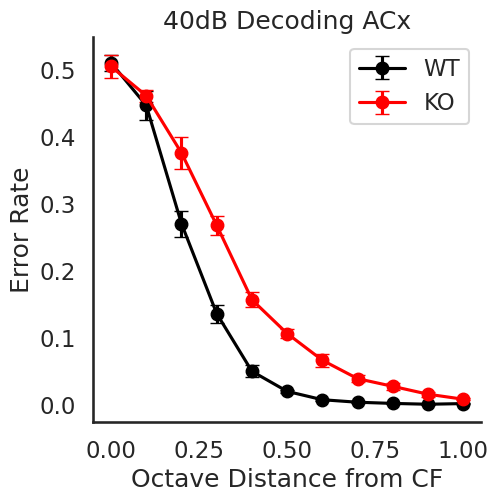

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.3
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

# Parameters for WT (wild-type) group
wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.77 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 28.43
ko_width_in_octaves = 2.135 #2.135 #2.54

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # 0.9 Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='black', label='WT', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='red', label='KO', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB Decoding ACx')
plt.legend()
sns.despine()
plt.savefig('ACx_decode_std.svg', dpi=600, bbox_inches='tight')
plt.show()



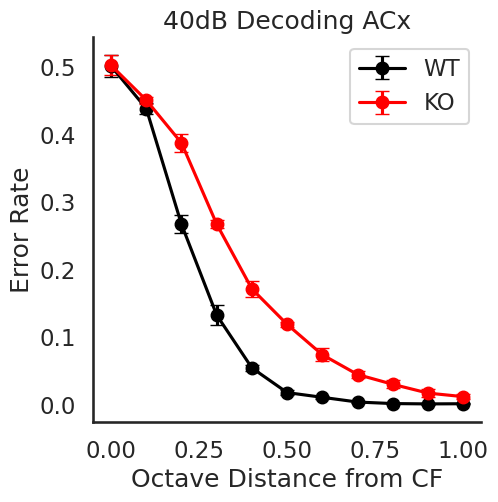

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.3
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

# Parameters for WT (wild-type) group
wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 28.43
ko_width_in_octaves = 1.7 #2.135 #2.54

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # 0.9 Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='black', label='WT', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='red', label='KO', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB Decoding ACx')
plt.legend()
sns.despine()
plt.savefig('ACx_decode_std.svg', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.3
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

wt_amplitude = 52.81
wt_noise_level = 28.43
wt_width_in_octaves = 1.7 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 28.43
ko_width_in_octaves = 1.7 #2.135 #2.54

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # 0.9 Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='orange', label='KO (wt amp)', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='red', label='KO', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB Decoding ACx')
plt.legend()
sns.despine()
plt.savefig('ACx_decode_ko_w_wt_amp.svg', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd

# Create a DataFrame to store the data for both WT and KO groups
# Each row will represent an octave distance and each column will represent a different repeat
data = {
    'Octave Distance from CF': wt_octave_distances
}

# Add the WT and KO error rates for each repeat
for repeat_idx in range(num_repeats):
    data[f'WT Repeat {repeat_idx + 1} Error Rate'] = wt_errors[repeat_idx]
    data[f'KO Repeat {repeat_idx + 1} Error Rate'] = ko_errors[repeat_idx]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('acx_std_error_model.csv', index=False)


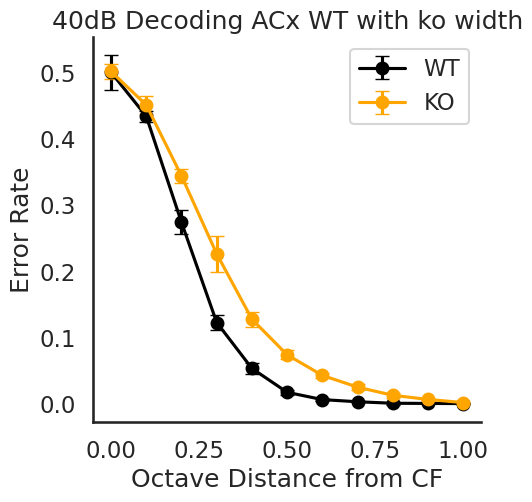

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.3
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

# Parameters for WT (wild-type) group
wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 52.81
ko_noise_level = 19.29
ko_width_in_octaves = 1.6 #2.135 #2.54

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # 0.9 Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='black', label='WT', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='orange', label='KO', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB Decoding ACx WT with ko width')
plt.legend()
sns.despine()
plt.savefig('ACx_wt_w_ko_width.svg', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd

# Create a DataFrame to store the data for both WT and KO groups
# Each row will represent an octave distance and each column will represent a different repeat
data = {
    'Octave Distance from CF': wt_octave_distances
}

# Add the WT and KO error rates for each repeat
for repeat_idx in range(num_repeats):
    data[f'WT Repeat {repeat_idx + 1} Error Rate'] = wt_errors[repeat_idx]
    data[f'KO Repeat {repeat_idx + 1} Error Rate'] = ko_errors[repeat_idx]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('acx_wt_w_ko_width_error_model.csv', index=False)


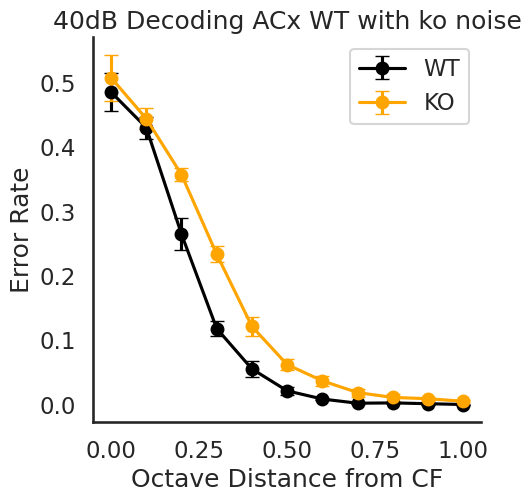

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.3
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 52.81
ko_noise_level = 28.43
ko_width_in_octaves = 1.1 #2.135 #2.54

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # 0.9 Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='black', label='WT', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='orange', label='KO', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB Decoding ACx WT with ko noise')
plt.legend()
sns.despine()
plt.savefig('ACx_wt_w_ko_noise.svg', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd

# Create a DataFrame to store the data for both WT and KO groups
# Each row will represent an octave distance and each column will represent a different repeat
data = {
    'Octave Distance from CF': wt_octave_distances
}

# Add the WT and KO error rates for each repeat
for repeat_idx in range(num_repeats):
    data[f'WT Repeat {repeat_idx + 1} Error Rate'] = wt_errors[repeat_idx]
    data[f'KO Repeat {repeat_idx + 1} Error Rate'] = ko_errors[repeat_idx]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('acx_wt_w_ko_noise_error_model.csv', index=False)


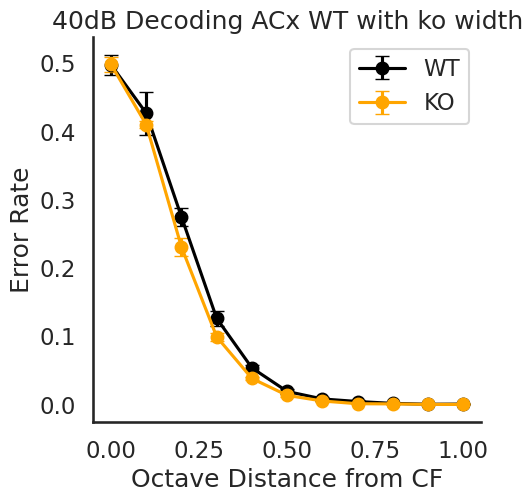

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.3
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

# Parameters for WT (wild-type) group
wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 19.29
ko_width_in_octaves = 1.1 #2.135 #2.54

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # 0.9 Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='black', label='WT', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='orange', label='KO', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB Decoding ACx WT with ko width')
plt.legend()
sns.despine()
plt.savefig('ACx_wt_w_ko_amp.svg', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd

# Create a DataFrame to store the data for both WT and KO groups
# Each row will represent an octave distance and each column will represent a different repeat
data = {
    'Octave Distance from CF': wt_octave_distances
}

# Add the WT and KO error rates for each repeat
for repeat_idx in range(num_repeats):
    data[f'WT Repeat {repeat_idx + 1} Error Rate'] = wt_errors[repeat_idx]
    data[f'KO Repeat {repeat_idx + 1} Error Rate'] = ko_errors[repeat_idx]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('acx_wt_w_ko_amp_error_model.csv', index=False)


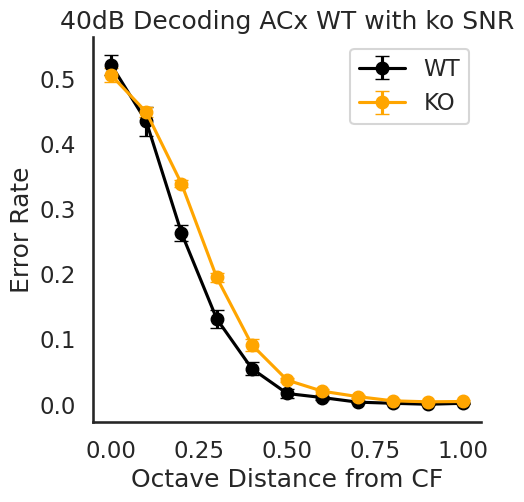

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.3
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

# Parameters for WT (wild-type) group
wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 28.43
ko_width_in_octaves = 1.1 #2.135 #2.54

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # 0.9 Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='black', label='WT', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='orange', label='KO', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB Decoding ACx WT with ko SNR')
plt.legend()
sns.despine()
plt.savefig('ACx_wt_w_ko_SNR.svg', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd

# Create a DataFrame to store the data for both WT and KO groups
# Each row will represent an octave distance and each column will represent a different repeat
data = {
    'Octave Distance from CF': wt_octave_distances
}

# Add the WT and KO error rates for each repeat
for repeat_idx in range(num_repeats):
    data[f'WT Repeat {repeat_idx + 1} Error Rate'] = wt_errors[repeat_idx]
    data[f'KO Repeat {repeat_idx + 1} Error Rate'] = ko_errors[repeat_idx]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('acx_wt_w_ko_snr_error_model.csv', index=False)


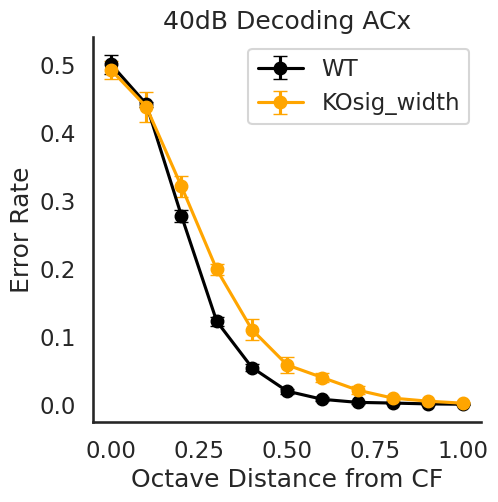

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.3
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

# Parameters for WT (wild-type) group
wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 19.29
ko_width_in_octaves = 1.7 #2.135 #2.54

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # 0.9 Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='black', label='WT', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='orange', label='KOsig_width', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB Decoding ACx')
plt.legend()
sns.despine()
plt.savefig('ACx_decode_wt_w_ko_signal_width.svg', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd

# Create a DataFrame to store the data for both WT and KO groups
# Each row will represent an octave distance and each column will represent a different repeat
data = {
    'Octave Distance from CF': wt_octave_distances
}

# Add the WT and KO error rates for each repeat
for repeat_idx in range(num_repeats):
    data[f'WT Repeat {repeat_idx + 1} Error Rate'] = wt_errors[repeat_idx]
    data[f'KO Repeat {repeat_idx + 1} Error Rate'] = ko_errors[repeat_idx]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('acx_wt_w_ko_sig_width_error_model.csv', index=False)


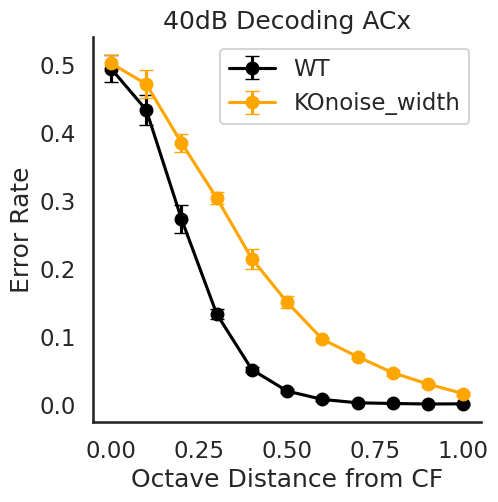

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.3
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

# Parameters for WT (wild-type) group
wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 52.81
ko_noise_level = 28.43
ko_width_in_octaves = 1.7 #2.135 #2.54

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # 0.9 Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='black', label='WT', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='orange', label='KOnoise_width', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB Decoding ACx')
plt.legend()
sns.despine()
plt.savefig('ACx_decode_wt_w_ko_noise_width.svg', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd

# Create a DataFrame to store the data for both WT and KO groups
# Each row will represent an octave distance and each column will represent a different repeat
data = {
    'Octave Distance from CF': wt_octave_distances
}

# Add the WT and KO error rates for each repeat
for repeat_idx in range(num_repeats):
    data[f'WT Repeat {repeat_idx + 1} Error Rate'] = wt_errors[repeat_idx]
    data[f'KO Repeat {repeat_idx + 1} Error Rate'] = ko_errors[repeat_idx]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('acx_wt_w_ko_noise_width_error_model.csv', index=False)


#Stats for ACx

In [ ]:
# width

# noise

# signal

# amp

# SNR

# standard

##standard stats

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the data from your csv file
data = pd.read_csv('/content/acx_std_error_model.csv')

# Reshape the data to a long format using pandas' melt function
data_long = pd.melt(data, id_vars=['Octave Distance from CF'],
                    value_vars=['WT Repeat 1 Error Rate', 'KO Repeat 1 Error Rate',
                                'WT Repeat 2 Error Rate', 'KO Repeat 2 Error Rate',
                                'WT Repeat 3 Error Rate', 'KO Repeat 3 Error Rate',
                                'WT Repeat 4 Error Rate', 'KO Repeat 4 Error Rate',
                                'WT Repeat 5 Error Rate', 'KO Repeat 5 Error Rate'],
                    var_name='Genotype_Repeat', value_name='Error')

# Create a new column to indicate whether the row is 'WT' or 'KO'
data_long['Genotype'] = data_long['Genotype_Repeat'].apply(lambda x: 'WT' if 'WT' in x else 'KO')
data_long['Octaves'] = data_long['Octave Distance from CF']

# Run a one-way ANOVA
# Model: Error ~ Genotype + Octave Distance from CF
model = ols('Error ~ C(Genotype) + Octaves', data=data_long).fit()

# Perform ANOVA
anova_results = anova_lm(model)

# Show the ANOVA table
print("Standard ANOVA Results:")
print(anova_results)



Standard ANOVA Results:
                df    sum_sq   mean_sq           F        PR(>F)
C(Genotype)    1.0  0.094698  0.094698   16.283774  1.026250e-04
Octaves        1.0  2.827539  2.827539  486.209952  1.361239e-41
Residual     107.0  0.622255  0.005815         NaN           NaN


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the data from your csv file
data = pd.read_csv('/content/acx_wt_w_ko_noise_error_model.csv')

# Reshape the data to a long format using pandas' melt function
data_long = pd.melt(data, id_vars=['Octave Distance from CF'],
                    value_vars=['WT Repeat 1 Error Rate', 'KO Repeat 1 Error Rate',
                                'WT Repeat 2 Error Rate', 'KO Repeat 2 Error Rate',
                                'WT Repeat 3 Error Rate', 'KO Repeat 3 Error Rate',
                                'WT Repeat 4 Error Rate', 'KO Repeat 4 Error Rate',
                                'WT Repeat 5 Error Rate', 'KO Repeat 5 Error Rate'],
                    var_name='Genotype_Repeat', value_name='Error')

# Create a new column to indicate whether the row is 'WT' or 'KO'
data_long['Genotype'] = data_long['Genotype_Repeat'].apply(lambda x: 'WT' if 'WT' in x else 'KO')
data_long['Octaves'] = data_long['Octave Distance from CF']

# Run a one-way ANOVA
# Model: Error ~ Genotype + Octave Distance from CF
model = ols('Error ~ C(Genotype) + Octaves', data=data_long).fit()

# Perform ANOVA
anova_results = anova_lm(model)

# Show the ANOVA table
print("Noise ANOVA Results:")
print(anova_results)



Noise ANOVA Results:
                df    sum_sq   mean_sq           F        PR(>F)
C(Genotype)    1.0  0.039520  0.039520    5.759916  1.812328e-02
Octaves        1.0  2.758507  2.758507  402.041358  4.979244e-38
Residual     107.0  0.734154  0.006861         NaN           NaN


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the data from your csv file
data = pd.read_csv('/content/acx_wt_w_ko_width_error_model.csv')

# Reshape the data to a long format using pandas' melt function
data_long = pd.melt(data, id_vars=['Octave Distance from CF'],
                    value_vars=['WT Repeat 1 Error Rate', 'KO Repeat 1 Error Rate',
                                'WT Repeat 2 Error Rate', 'KO Repeat 2 Error Rate',
                                'WT Repeat 3 Error Rate', 'KO Repeat 3 Error Rate',
                                'WT Repeat 4 Error Rate', 'KO Repeat 4 Error Rate',
                                'WT Repeat 5 Error Rate', 'KO Repeat 5 Error Rate'],
                    var_name='Genotype_Repeat', value_name='Error')

# Create a new column to indicate whether the row is 'WT' or 'KO'
data_long['Genotype'] = data_long['Genotype_Repeat'].apply(lambda x: 'WT' if 'WT' in x else 'KO')
data_long['Octaves'] = data_long['Octave Distance from CF']

# Run a one-way ANOVA
# Model: Error ~ Genotype + Octave Distance from CF
model = ols('Error ~ C(Genotype) + Octaves', data=data_long).fit()

# Perform ANOVA
anova_results = anova_lm(model)

# Show the ANOVA table
print("Width ANOVA Results:")
print(anova_results)



Width ANOVA Results:
                df    sum_sq   mean_sq           F        PR(>F)
C(Genotype)    1.0  0.036455  0.036455    5.447197  2.146782e-02
Octaves        1.0  2.792664  2.792664  417.291368  1.022531e-38
Residual     107.0  0.716083  0.006692         NaN           NaN


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the data from your csv file
data = pd.read_csv('/content/acx_wt_w_ko_amp_error_model.csv')

# Reshape the data to a long format using pandas' melt function
data_long = pd.melt(data, id_vars=['Octave Distance from CF'],
                    value_vars=['WT Repeat 1 Error Rate', 'KO Repeat 1 Error Rate',
                                'WT Repeat 2 Error Rate', 'KO Repeat 2 Error Rate',
                                'WT Repeat 3 Error Rate', 'KO Repeat 3 Error Rate',
                                'WT Repeat 4 Error Rate', 'KO Repeat 4 Error Rate',
                                'WT Repeat 5 Error Rate', 'KO Repeat 5 Error Rate'],
                    var_name='Genotype_Repeat', value_name='Error')

# Create a new column to indicate whether the row is 'WT' or 'KO'
data_long['Genotype'] = data_long['Genotype_Repeat'].apply(lambda x: 'WT' if 'WT' in x else 'KO')
data_long['Octaves'] = data_long['Octave Distance from CF']

# Run a one-way ANOVA
# Model: Error ~ Genotype + Octave Distance from CF
model = ols('Error ~ C(Genotype) + Octaves', data=data_long).fit()

# Perform ANOVA
anova_results = anova_lm(model)

# Show the ANOVA table
print("Amp ANOVA Results:")
print(anova_results)



Amp ANOVA Results:
                df    sum_sq   mean_sq           F        PR(>F)
C(Genotype)    1.0  0.003085  0.003085    0.353911  5.531636e-01
Octaves        1.0  2.434838  2.434838  279.360309  1.327600e-31
Residual     107.0  0.932586  0.008716         NaN           NaN


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the data from your csv file
data = pd.read_csv('/content/acx_wt_w_ko_snr_error_model.csv')

# Reshape the data to a long format using pandas' melt function
data_long = pd.melt(data, id_vars=['Octave Distance from CF'],
                    value_vars=['WT Repeat 1 Error Rate', 'KO Repeat 1 Error Rate',
                                'WT Repeat 2 Error Rate', 'KO Repeat 2 Error Rate',
                                'WT Repeat 3 Error Rate', 'KO Repeat 3 Error Rate',
                                'WT Repeat 4 Error Rate', 'KO Repeat 4 Error Rate',
                                'WT Repeat 5 Error Rate', 'KO Repeat 5 Error Rate'],
                    var_name='Genotype_Repeat', value_name='Error')

# Create a new column to indicate whether the row is 'WT' or 'KO'
data_long['Genotype'] = data_long['Genotype_Repeat'].apply(lambda x: 'WT' if 'WT' in x else 'KO')
data_long['Octaves'] = data_long['Octave Distance from CF']

# Run a one-way ANOVA
# Model: Error ~ Genotype + Octave Distance from CF
model = ols('Error ~ C(Genotype) + Octaves', data=data_long).fit()

# Perform ANOVA
anova_results = anova_lm(model)

# Show the ANOVA table
print("SNR ANOVA Results:")
print(anova_results)



SNR ANOVA Results:
                df    sum_sq   mean_sq           F        PR(>F)
C(Genotype)    1.0  0.011277  0.011277    1.436044  2.334281e-01
Octaves        1.0  2.816523  2.816523  358.672675  5.908207e-36
Residual     107.0  0.840231  0.007853         NaN           NaN


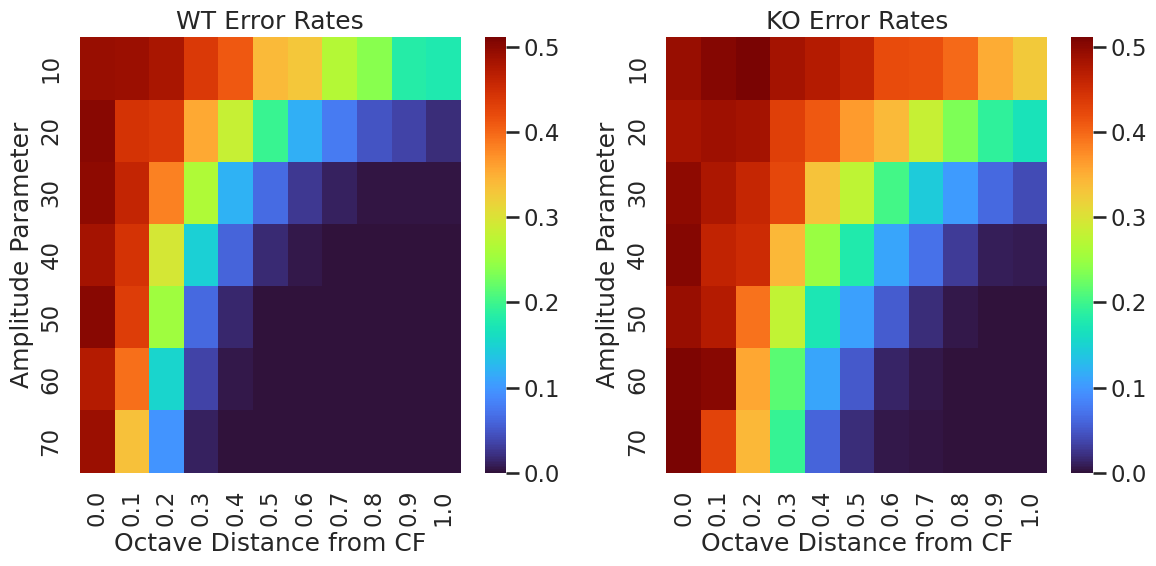

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, poisson

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.1
num_neurons = 10
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))



# Parameters for WT (wild-type) group

# Parameters for WT (wild-type) group

wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 28.43
ko_width_in_octaves = 1.7 #2.135 #2.54



num_trials = 10  # Number of trials to average
threshold_factor = 0.9  # Thresholding

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(8 * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor):
    errors = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    for od in octave_distances:
        total_errors = 0
        for CF in characteristic_frequencies:
            go_frequency = CF
            no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
            trial_errors = 0
            for no_go_frequency in no_go_frequencies:
                for _ in range(num_trials):
                    # Simulate activity for go frequency with thresholding
                    activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    # Apply Bayesian decoding to classify go vs no-go
                    is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    if not is_go:
                        trial_errors += 1
            total_errors += trial_errors / (num_trials * len(no_go_frequencies))
        errors.append(total_errors / len(characteristic_frequencies))
    return octave_distances, errors

# Define a range of amplitude parameters to test
amplitude_parameters = np.linspace(1, 200, 10)
amplitude_parameters = [10,20,30,40,50,60,70]

# Initialize arrays to store error rates
wt_error_matrix = np.zeros((len(amplitude_parameters), 11))
ko_error_matrix = np.zeros((len(amplitude_parameters), 11))

# Calculate error rates for each amplitude parameter
for i, amp in enumerate(amplitude_parameters):
    wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, amp, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor)
    ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, amp, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor)
    wt_error_matrix[i, :] = wt_errors
    ko_error_matrix[i, :] = ko_errors

# Determine the common scale for the heatmaps
vmin = min(wt_error_matrix.min(), ko_error_matrix.min())
vmax = max(wt_error_matrix.max(), ko_error_matrix.max())

# Plot heatmaps
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(wt_error_matrix, xticklabels=np.round(wt_octave_distances, 2), yticklabels=np.round(amplitude_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Amplitude Parameter')
plt.title('WT Error Rates')

plt.subplot(1, 2, 2)
sns.heatmap(ko_error_matrix, xticklabels=np.round(ko_octave_distances, 2), yticklabels=np.round(amplitude_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Amplitude Parameter')
plt.title('KO Error Rates')

plt.tight_layout()
plt.savefig('gain_heatmaps.svg', dpi=600, bbox_inches='tight')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, poisson

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.1
num_neurons = 10
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))


wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 28.43
ko_width_in_octaves = 1.7 #2.135 #2.54
# Parameters for WT (wild-type) group

# Parameters for WT (wild-type) group

wt_noise_level = 11.8
wt_width_in_octaves = 1.65


ko_noise_level = 18.3
ko_width_in_octaves = 2.77



num_trials = 10  # Number of trials to average
threshold_factor = 0.9  # Thresholding

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(8 * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor):
    errors = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    for od in octave_distances:
        total_errors = 0
        for CF in characteristic_frequencies:
            go_frequency = CF
            no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
            trial_errors = 0
            for no_go_frequency in no_go_frequencies:
                for _ in range(num_trials):
                    # Simulate activity for go frequency with thresholding
                    activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    # Apply Bayesian decoding to classify go vs no-go
                    is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    if not is_go:
                        trial_errors += 1
            total_errors += trial_errors / (num_trials * len(no_go_frequencies))
        errors.append(total_errors / len(characteristic_frequencies))
    return octave_distances, errors

# Define a range of amplitude parameters to test
amplitude_parameters = np.linspace(1, 200, 10)
amplitude_parameters = [5,10,15,20,25,30,35,45,50,55,60,70,100,150,200,300]

# Initialize arrays to store error rates
wt_error_matrix = np.zeros((len(amplitude_parameters), 11))
ko_error_matrix = np.zeros((len(amplitude_parameters), 11))

# Calculate error rates for each amplitude parameter
for i, amp in enumerate(amplitude_parameters):
    wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, amp, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor)
    ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, amp, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor)
    wt_error_matrix[i, :] = wt_errors
    ko_error_matrix[i, :] = ko_errors

# Determine the common scale for the heatmaps
vmin = min(wt_error_matrix.min(), ko_error_matrix.min())
vmax = max(wt_error_matrix.max(), ko_error_matrix.max())

# Plot heatmaps
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(wt_error_matrix, xticklabels=np.round(wt_octave_distances, 2), yticklabels=np.round(amplitude_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Amplitude Parameter')
plt.title('WT Error Rates')

plt.subplot(1, 2, 2)
sns.heatmap(ko_error_matrix, xticklabels=np.round(ko_octave_distances, 2), yticklabels=np.round(amplitude_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Amplitude Parameter')
plt.title('KO Error Rates')

plt.tight_layout()
plt.savefig('gain_heatmaps.svg', dpi=600, bbox_inches='tight')

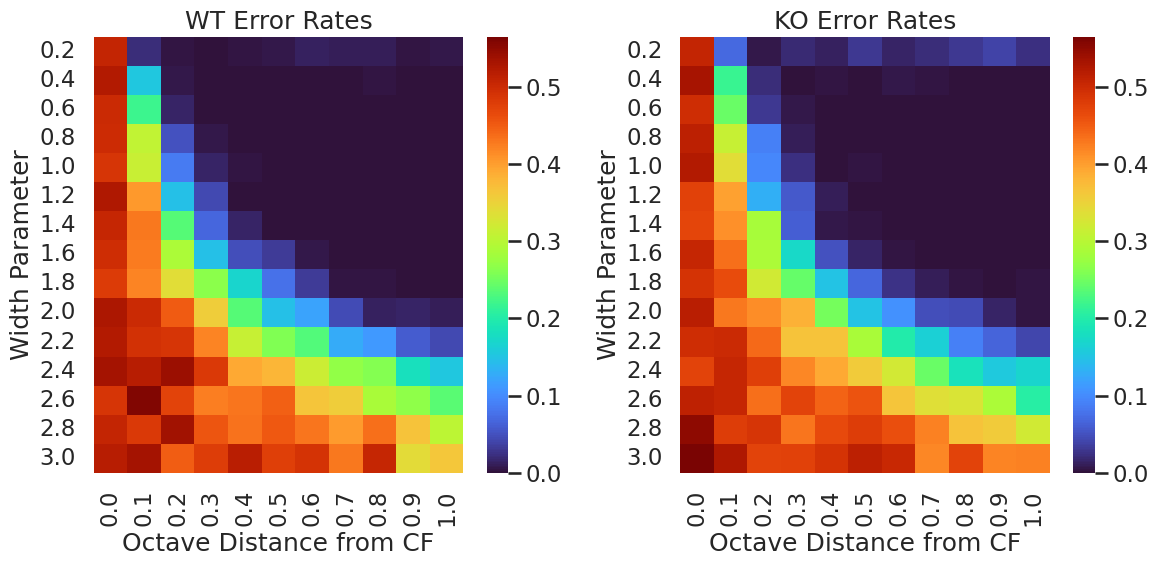

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, poisson

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.1
num_neurons = 10
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 28.43
ko_width_in_octaves = 1.7 #2.135 #2.54


num_trials = 10  # Number of trials to average
threshold_factor = 0.9  # Thresholding
# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(8 * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor):
    errors = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    for od in octave_distances:
        total_errors = 0
        for CF in characteristic_frequencies:
            go_frequency = CF
            no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
            trial_errors = 0
            for no_go_frequency in no_go_frequencies:
                for _ in range(num_trials):
                    # Simulate activity for go frequency with thresholding
                    activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    # Apply Bayesian decoding to classify go vs no-go
                    is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    if not is_go:
                        trial_errors += 1
            total_errors += trial_errors / (num_trials * len(no_go_frequencies))
        errors.append(total_errors / len(characteristic_frequencies))
    return octave_distances, errors

# Define a range of bandwidth parameters to test
bandwidth_parameters = np.linspace(0.3, 3.0, 20)
bandwidth_parameters = [0.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3]

# Initialize arrays to store error rates
wt_error_matrix = np.zeros((len(bandwidth_parameters), 11))
ko_error_matrix = np.zeros((len(bandwidth_parameters), 11))

# Calculate error rates for each bandwidth parameter
for i, bw in enumerate(bandwidth_parameters):
    wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, bw, num_trials, threshold_factor)
    ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, bw, num_trials, threshold_factor)
    wt_error_matrix[i, :] = wt_errors
    ko_error_matrix[i, :] = ko_errors

# Determine the common scale for the heatmaps
vmin = min(wt_error_matrix.min(), ko_error_matrix.min())
vmax = max(wt_error_matrix.max(), ko_error_matrix.max())

# Plot heatmaps
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(wt_error_matrix, xticklabels=np.round(wt_octave_distances, 2), yticklabels=np.round(bandwidth_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Width Parameter')
plt.title('WT Error Rates')

plt.subplot(1, 2, 2)
sns.heatmap(ko_error_matrix, xticklabels=np.round(ko_octave_distances, 2), yticklabels=np.round(bandwidth_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Width Parameter')
plt.title('KO Error Rates')

plt.tight_layout()
plt.savefig('bw_heatmaps.svg', dpi=600, bbox_inches='tight')

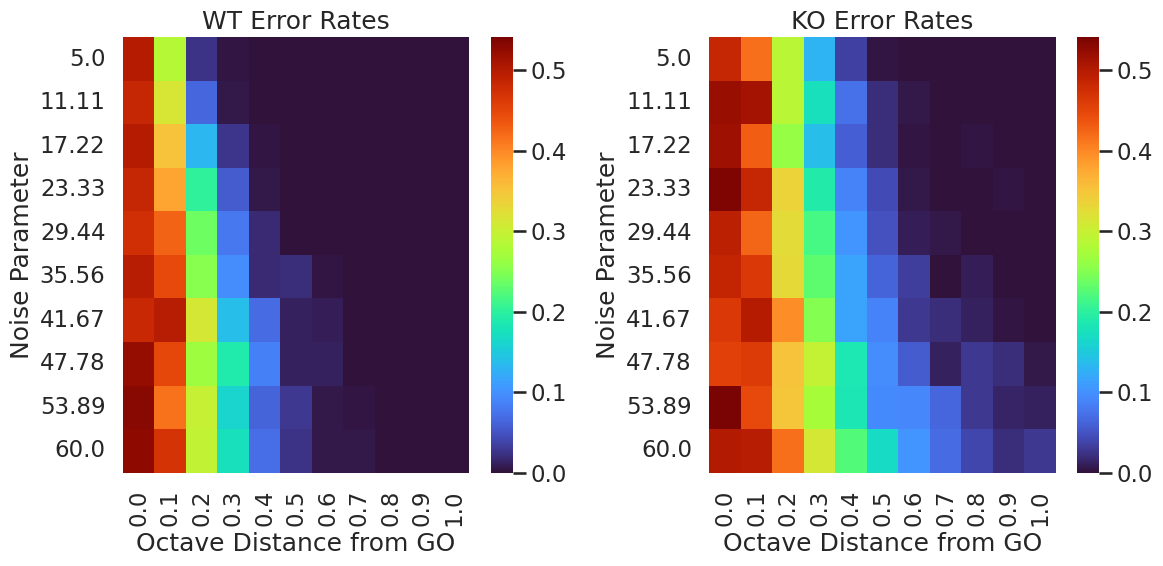

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, poisson

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.1
num_neurons = 10
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 28.43
ko_width_in_octaves = 1.7 #2.135 #2.54


num_trials = 10  # Number of trials to average
threshold_factor = 1.2  # Thresholding

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(8 * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor):
    errors = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    for od in octave_distances:
        total_errors = 0
        for CF in characteristic_frequencies:
            go_frequency = CF
            no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
            trial_errors = 0
            for no_go_frequency in no_go_frequencies:
                for _ in range(num_trials):
                    # Simulate activity for go frequency with thresholding
                    activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    # Apply Bayesian decoding to classify go vs no-go
                    is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    if not is_go:
                        trial_errors += 1
            total_errors += trial_errors / (num_trials * len(no_go_frequencies))
        errors.append(total_errors / len(characteristic_frequencies))
    return octave_distances, errors

# Define a range of noise parameters to test
noise_parameters = np.linspace(5, 60, 10)

# Initialize arrays to store error rates
wt_error_matrix = np.zeros((len(noise_parameters), 11))
ko_error_matrix = np.zeros((len(noise_parameters), 11))

# Calculate error rates for each noise parameter
for i, noise in enumerate(noise_parameters):
    wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, noise, wt_width_in_octaves, num_trials, threshold_factor)
    ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, noise, ko_width_in_octaves, num_trials, threshold_factor)
    wt_error_matrix[i, :] = wt_errors
    ko_error_matrix[i, :] = ko_errors

# Determine the common scale for the heatmaps
vmin = min(wt_error_matrix.min(), ko_error_matrix.min())
vmax = max(wt_error_matrix.max(), ko_error_matrix.max())

# Plot heatmaps
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(wt_error_matrix, xticklabels=np.round(wt_octave_distances, 2), yticklabels=np.round(noise_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from GO')
plt.ylabel('Noise Parameter')
plt.title('WT Error Rates')

plt.subplot(1, 2, 2)
sns.heatmap(ko_error_matrix, xticklabels=np.round(ko_octave_distances, 2), yticklabels=np.round(noise_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from GO')
plt.ylabel('Noise Parameter')
plt.title('KO Error Rates')

plt.tight_layout()
plt.savefig('noise_heatmaps.svg', dpi=600, bbox_inches='tight')

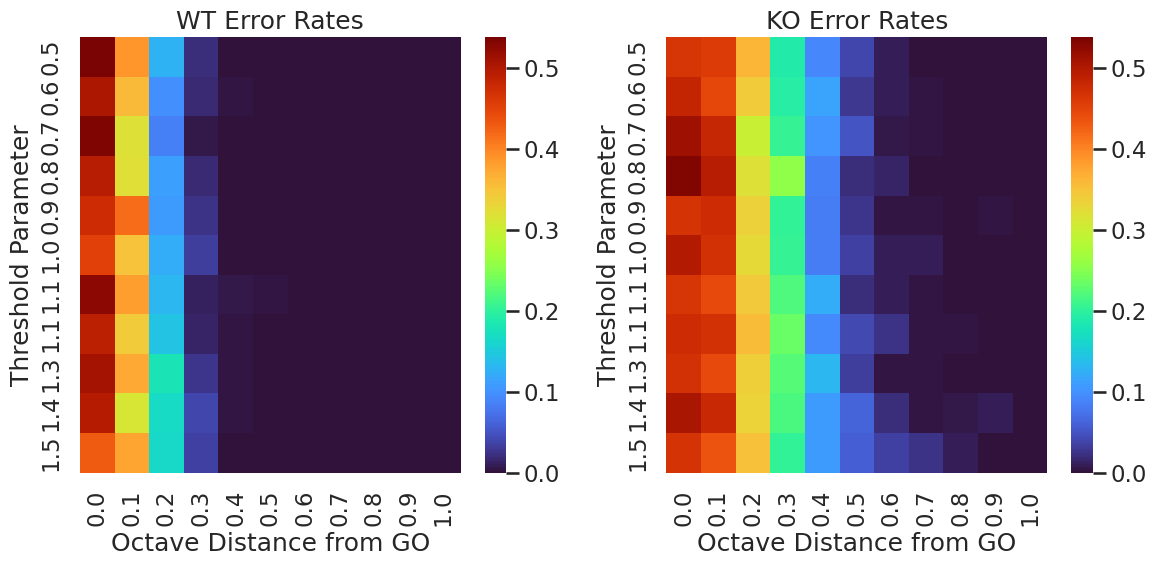

In [ ]:
# heatmap for thresholding for each genotype with their respective parameters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, poisson

# Define parameters for WT and KO groups
start = 2
end = 64
oct_step = 0.1
num_neurons = 10
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

wt_amplitude = 52.81
wt_noise_level = 19.29
wt_width_in_octaves = 1.1 #1.68 #1.77

ko_amplitude = 59.1
ko_noise_level = 28.43
ko_width_in_octaves = 1.7 #2.135 #2.54


num_trials = 10  # Number of trials to average

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(8 * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor):
    errors = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    for od in octave_distances:
        total_errors = 0
        for CF in characteristic_frequencies:
            go_frequency = CF
            no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
            trial_errors = 0
            for no_go_frequency in no_go_frequencies:
                for _ in range(num_trials):
                    # Simulate activity for go frequency with thresholding
                    activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    # Apply Bayesian decoding to classify go vs no-go
                    is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                    if not is_go:
                        trial_errors += 1
            total_errors += trial_errors / (num_trials * len(no_go_frequencies))
        errors.append(total_errors / len(characteristic_frequencies))
    return octave_distances, errors

# Define a range of threshold parameters to test
threshold_parameters = np.linspace(0.5, 1.5, 10)
threshold_parameters = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.1,1.3,1.4,1.5]

# Initialize arrays to store error rates
wt_error_matrix = np.zeros((len(threshold_parameters), 11))
ko_error_matrix = np.zeros((len(threshold_parameters), 11))

# Calculate error rates for each threshold parameter
for i, threshold in enumerate(threshold_parameters):
    wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold)
    ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold)
    wt_error_matrix[i, :] = wt_errors
    ko_error_matrix[i, :] = ko_errors

# Determine the common scale for the heatmaps
vmin = min(wt_error_matrix.min(), ko_error_matrix.min())
vmax = max(wt_error_matrix.max(), ko_error_matrix.max())

# Plot heatmaps
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(wt_error_matrix, xticklabels=np.round(wt_octave_distances, 2), yticklabels=np.round(threshold_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from GO')
plt.ylabel('Threshold Parameter')
plt.title('WT Error Rates')

plt.subplot(1, 2, 2)
sns.heatmap(ko_error_matrix, xticklabels=np.round(ko_octave_distances, 2), yticklabels=np.round(threshold_parameters, 2), cmap='turbo', vmin=vmin, vmax=vmax)
plt.xlabel('Octave Distance from GO')
plt.ylabel('Threshold Parameter')
plt.title('KO Error Rates')

plt.tight_layout()
plt.savefig('threshold_heatmaps.svg', dpi=600, bbox_inches='tight')

# IC

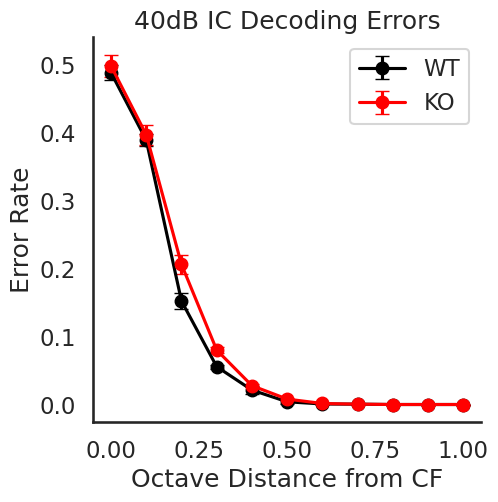

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns

# Define parameters for WT and KO groups

start = 2
end = 64
oct_step = 0.05
num_steps = int(np.log2(end/start)/oct_step)+1
characteristic_frequencies = start*(2**(np.arange(num_steps)*oct_step))

#num_neurons = 50
#characteristic_frequencies = np.linspace(4, 32, num_neurons)  # CFs spaced evenly from 8 to 16 kHz

# Parameters for WT (wild-type) group
wt_amplitude = 59.5 # 110
wt_noise_level = 22.1 # 45
wt_width_in_octaves = 1.56 # 1

# Parameters for KO (knockout) group
ko_amplitude = 60.4 #260
ko_noise_level = 27.2 #130
ko_width_in_octaves = 1.47 # 1.77

num_trials = 100  # Number of trials to average
threshold_factor = 0.9  # Thresholding
num_repeats = 5  # Number of repeats for error bars

# Function to compute sigma based on width in octaves
def compute_sigma(CF, width_in_octaves):
    return CF * (2 ** width_in_octaves - 1) / np.sqrt(CF * np.log(2))

# Generate Gaussian tuning curves with Poisson variability and apply thresholding
def simulate_neuron_activity(stimulus_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    activities = []
    for CF in characteristic_frequencies:
        sigma = compute_sigma(CF, width_in_octaves)
        mean_activity = amplitude * np.exp(-((np.log2(stimulus_frequency) - np.log2(CF)) ** 2) / (2 * (sigma / CF) ** 2)) + noise_level
        # Draw from a Poisson distribution to simulate trial variability
        activity = poisson.rvs(mean_activity)
        # Apply thresholding
        threshold = threshold_factor * noise_level
        activity = np.where(activity >= threshold, activity, 0)
        activity = activity - (threshold_factor * noise_level)
        activities.append(activity)
    return np.array(activities)

# Apply Bayesian decoding for a go-no-go task with thresholded activities
def bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor):
    go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    no_go_likelihood = np.prod(norm.pdf(activities, simulate_neuron_activity(no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor), noise_level))
    return go_likelihood > no_go_likelihood

# Calculate the error rates as a function of octave distance with thresholding
def calculate_error_rates_go_no_go(characteristic_frequencies, amplitude, noise_level, width_in_octaves, num_trials, threshold_factor, num_repeats):
    errors_list = []
    octave_distances = np.linspace(0, 1, 11)  # From 0 to 1 octave
    stim_list = [4, 8, 16, 32]
    for repeat in range(num_repeats):
        errors = []
        for od in octave_distances:
            total_errors = 0
            for CF in stim_list:
                go_frequency = CF
                no_go_frequencies = [CF * (2 ** d) for d in [-od, od]]  # No-go frequencies at distance
                trial_errors = 0
                for no_go_frequency in no_go_frequencies:
                    for _ in range(num_trials):
                        # Simulate activity for go frequency with thresholding
                        activities = simulate_neuron_activity(go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        # Apply Bayesian decoding to classify go vs no-go
                        is_go = bayesian_decoding_go_no_go(activities, go_frequency, no_go_frequency, characteristic_frequencies, amplitude, noise_level, width_in_octaves, threshold_factor)
                        if not is_go:
                            trial_errors += 1
                total_errors += trial_errors / (num_trials * len(no_go_frequencies))
            errors.append(total_errors / len(stim_list))
        errors_list.append(errors)

    # Convert list of errors for all repeats into a numpy array
    errors_array = np.array(errors_list)
    return octave_distances, errors_array

# Calculate error rates for WT group with thresholding
wt_octave_distances, wt_errors = calculate_error_rates_go_no_go(characteristic_frequencies, wt_amplitude, wt_noise_level, wt_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate error rates for KO group with thresholding
ko_octave_distances, ko_errors = calculate_error_rates_go_no_go(characteristic_frequencies, ko_amplitude, ko_noise_level, ko_width_in_octaves, num_trials, threshold_factor, num_repeats)

# Calculate means and standard deviations for error rates
wt_mean_errors = wt_errors.mean(axis=0)
wt_std_errors = wt_errors.std(axis=0)

ko_mean_errors = ko_errors.mean(axis=0)
ko_std_errors = ko_errors.std(axis=0)

# Plot the error rate as a function of octave distance from CF with error bars
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(5,5))
plt.errorbar(wt_octave_distances, wt_mean_errors, yerr=wt_std_errors, fmt='-o', color='black', label='WT', capsize=5)
plt.errorbar(ko_octave_distances, ko_mean_errors, yerr=ko_std_errors, fmt='-o', color='red', label='KO', capsize=5)
plt.xlabel('Octave Distance from CF')
plt.ylabel('Error Rate')
plt.title('40dB IC Decoding Errors')
plt.legend()
sns.despine()
plt.savefig('IC_decode_std.svg', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd

# Create a DataFrame to store the data for both WT and KO groups
# Each row will represent an octave distance and each column will represent a different repeat
data = {
    'Octave Distance from CF': wt_octave_distances
}

# Add the WT and KO error rates for each repeat
for repeat_idx in range(num_repeats):
    data[f'WT Repeat {repeat_idx + 1} Error Rate'] = wt_errors[repeat_idx]
    data[f'KO Repeat {repeat_idx + 1} Error Rate'] = ko_errors[repeat_idx]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('ic_std_error_model.csv', index=False)
